# Module 04


In [1]:
import random
from collections import Counter
from pathlib import Path

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import polars.selectors as cs
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    mutual_info_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import KFold, train_test_split
from tqdm.auto import tqdm

from ml_zoomcamp.utils import clean_column_names, load_data

alt.data_transformers.disable_max_rows()

ROOT_DIR = Path.cwd().parent
DATA_DIR = ROOT_DIR.joinpath("data")

/home/nikki/workspace/ml-zoomcamp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data Preparation


In [2]:
csv_uri = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = load_data(csv_uri, DATA_DIR)
df = clean_column_names(df)

df = df.with_columns(
    cs.string()
    .str.to_lowercase()
    .str.replace_all(r"[^\w\s-]", "")
    .str.replace_all(r"\s+|-+", "_")
)

In [3]:
df.schema

Schema([('customerid', String),
        ('gender', String),
        ('seniorcitizen', Int64),
        ('partner', String),
        ('dependents', String),
        ('tenure', Int64),
        ('phoneservice', String),
        ('multiplelines', String),
        ('internetservice', String),
        ('onlinesecurity', String),
        ('onlinebackup', String),
        ('deviceprotection', String),
        ('techsupport', String),
        ('streamingtv', String),
        ('streamingmovies', String),
        ('contract', String),
        ('paperlessbilling', String),
        ('paymentmethod', String),
        ('monthlycharges', Float64),
        ('totalcharges', Float64),
        ('churn', String)])

In [4]:
df.glimpse()

Rows: 7043
Columns: 21
$ customerid       <str> '7590_vhveg', '5575_gnvde', '3668_qpybk', '7795_cfocw', '9237_hqitu', '9305_cdskc', '1452_kiovk', '6713_okomc', '7892_pookp', '6388_tabgu'
$ gender           <str> 'female', 'male', 'male', 'male', 'female', 'female', 'male', 'female', 'female', 'male'
$ seniorcitizen    <i64> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ partner          <str> 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no'
$ dependents       <str> 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'yes'
$ tenure           <i64> 1, 34, 2, 45, 2, 8, 22, 10, 28, 62
$ phoneservice     <str> 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'yes'
$ multiplelines    <str> 'no_phone_service', 'no', 'no', 'no_phone_service', 'no', 'yes', 'yes', 'no_phone_service', 'yes', 'no'
$ internetservice  <str> 'dsl', 'dsl', 'dsl', 'dsl', 'fiber_optic', 'fiber_optic', 'fiber_optic', 'dsl', 'fiber_optic', 'dsl'
$ onlinesecurity   <str> 'no', 'yes', 'yes', 'yes', 'no', 'no', 'no

In [ ]:
df.describe()

statistic,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
str,str,str,f64,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str
"""count""","""7043""","""7043""",7043.0,"""7043""","""7043""",7043.0,"""7043""","""7043""","""7043""","""7043""","""7043""","""7043""","""7043""","""7043""","""7043""","""7043""","""7043""","""7043""",7043.0,7032.0,"""7043"""
"""null_count""","""0""","""0""",0.0,"""0""","""0""",0.0,"""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,11.0,"""0"""
"""mean""",null,null,0.162147,null,null,32.371149,null,null,null,null,null,null,null,null,null,null,null,null,64.761692,2283.300441,null
"""std""",null,null,0.368612,null,null,24.559481,null,null,null,null,null,null,null,null,null,null,null,null,30.090047,2266.771362,null
"""min""","""0002_orfbo""","""female""",0.0,"""no""","""no""",0.0,"""no""","""no""","""dsl""","""no""","""no""","""no""","""no""","""no""","""no""","""month_to_month""","""no""","""bank_transfer_automatic""",18.25,18.8,"""no"""
"""25%""",null,null,0.0,null,null,9.0,null,null,null,null,null,null,null,null,null,null,null,null,35.5,401.5,null
"""50%""",null,null,0.0,null,null,29.0,null,null,null,null,null,null,null,null,null,null,null,null,70.35,1397.65,null
"""75%""",null,null,0.0,null,null,55.0,null,null,null,null,null,null,null,null,null,null,null,null,89.85,3794.5,null
"""max""","""9995_hotoh""","""male""",1.0,"""yes""","""yes""",72.0,"""yes""","""yes""","""no""","""yes""","""yes""","""yes""","""yes""","""yes""","""yes""","""two_year""","""yes""","""mailed_check""",118.75,8684.8,"""yes"""


In [ ]:
df.null_count().transpose(include_header=True, column_names=["null_count"]).filter(
    pl.col("null_count") > 0
).sort(pl.col("null_count"), descending=True)

column,null_count
str,u32
"""totalcharges""",11


In [ ]:
df.filter(pl.col("totalcharges").is_null()).select(pl.col("customerid", "totalcharges"))

customerid,totalcharges
str,f64
"""4472_lvygi""",null
"""3115_czmzd""",null
"""5709_lvoeq""",null
"""4367_nuyao""",null
"""1371_dwpaz""",null
…,…
"""3213_vvolg""",null
"""2520_sgtta""",null
"""2923_arzlg""",null


In [8]:
df = df.with_columns(pl.col("totalcharges").fill_null(0))

In [9]:
df = df.with_columns((pl.col("churn") == "yes").cast(pl.Int8))

## 2. Setting Up Validation Framework


In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [11]:
len(df_train), len(df_val), len(df_test)

(4225, 1409, 1409)

In [12]:
y_train = df_train["churn"].to_numpy()
y_val = df_val["churn"].to_numpy()
y_test = df_test["churn"].to_numpy()

In [13]:
df_train = df_train.drop("churn")
df_val = df_val.drop("churn")
df_test = df_test.drop("churn")

## 3. Exploratory Data Analysis


In [14]:
df_full_train.null_count().transpose(
    include_header=True, column_names=["null_count"]
).filter(pl.col("null_count") > 0)

column,null_count
str,u32


In [ ]:
df_full_train["churn"].value_counts(sort=True, normalize=True)

churn,proportion
i8,f64
0,0.730032
1,0.269968


In [16]:
global_churn_rate = df_full_train["churn"].mean()
round(global_churn_rate, 2)

0.27

In [17]:
numerical = ["tenure", "monthlycharges", "totalcharges"]

In [18]:
categorical = [
    "gender",
    "seniorcitizen",
    "partner",
    "dependents",
    "phoneservice",
    "multiplelines",
    "internetservice",
    "onlinesecurity",
    "onlinebackup",
    "deviceprotection",
    "techsupport",
    "streamingtv",
    "streamingmovies",
    "contract",
    "paperlessbilling",
    "paymentmethod",
]

In [19]:
df_full_train.select(pl.col(categorical).n_unique())

gender,seniorcitizen,partner,dependents,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4


## 4. Feature importance: Churn rate and Risk ratio


#### Churn rate


In [20]:
df_full_train.head()

customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
str,str,i64,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,i8
"""5442_pptjy""","""male""",0,"""yes""","""yes""",12,"""yes""","""no""","""no""","""no_internet_service""","""no_internet_service""","""no_internet_service""","""no_internet_service""","""no_internet_service""","""no_internet_service""","""two_year""","""no""","""mailed_check""",19.7,258.35,0
"""6261_rcvns""","""female""",0,"""no""","""no""",42,"""yes""","""no""","""dsl""","""yes""","""yes""","""yes""","""yes""","""no""","""yes""","""one_year""","""no""","""credit_card_automatic""",73.9,3160.55,1
"""2176_osjuv""","""male""",0,"""yes""","""no""",71,"""yes""","""yes""","""dsl""","""yes""","""yes""","""no""","""yes""","""no""","""no""","""two_year""","""no""","""bank_transfer_automatic""",65.15,4681.75,0
"""6161_erdgd""","""male""",0,"""yes""","""yes""",71,"""yes""","""yes""","""dsl""","""yes""","""no""","""yes""","""yes""","""yes""","""yes""","""one_year""","""no""","""electronic_check""",85.45,6300.85,0
"""2364_ufrom""","""male""",0,"""no""","""no""",30,"""yes""","""no""","""dsl""","""yes""","""yes""","""no""","""yes""","""yes""","""no""","""one_year""","""no""","""electronic_check""",70.4,2044.75,0


In [ ]:
churn_female = df_full_train.filter(pl.col("gender") == "female")["churn"].mean()
churn_female

0.27682403433476394

In [22]:
churn_male = df_full_train.filter(pl.col("gender") == "male")["churn"].mean()
churn_male

0.2632135306553911

In [ ]:
global_churn_rate

0.26996805111821087

In [ ]:
df_full_train["partner"].value_counts()

partner,count
str,u32
"""no""",2932
"""yes""",2702


In [25]:
churn_partner = df_full_train.filter(pl.col("partner") == "yes")["churn"].mean()
churn_partner

0.20503330866025166

In [ ]:
global_churn_rate - churn_partner

0.06493474245795922

In [27]:
churn_no_partner = df_full_train.filter(pl.col("partner") == "no")["churn"].mean()
churn_no_partner

0.3298090040927694

In [ ]:
global_churn_rate - churn_no_partner

-0.05984095297455855

`partner` may have a greater importance than `gender` in affecting churn

1. Difference (group - global)

   - difference < 0 -> less likely to churn
   - difference > 0 -> more likely to churn

1. Risk ratio (group / global)
   - risk < 1 -> less likely to churn
   - risk > 1 -> more likely to churn


In [ ]:
churn_no_partner / global_churn_rate

1.2216593879412643

In [30]:
churn_partner / global_churn_rate

0.7594724924338315

In [ ]:
df_full_train.group_by(pl.col("gender")).agg(
    pl.col("churn").mean().alias("mean"),
    pl.col("churn").count().alias("count"),
    (pl.col("churn").mean() - global_churn_rate).alias("diff"),
    (pl.col("churn").mean() / global_churn_rate).alias("risk"),
)

gender,mean,count,diff,risk
str,f64,u32,f64,f64
"""male""",0.263214,2838,-0.006755,0.97498
"""female""",0.276824,2796,0.006856,1.025396


In [ ]:
for c in categorical:
    print(c)
    df_group = df_full_train.group_by(pl.col(c)).agg(
        pl.col("churn").mean().alias("mean"),
        pl.col("churn").count().alias("count"),
        (pl.col("churn").mean() - global_churn_rate).alias("diff"),
        (pl.col("churn").mean() / global_churn_rate).alias("risk"),
    )
    print(df_group)

gender
shape: (2, 5)
┌────────┬──────────┬───────┬───────────┬──────────┐
│ gender ┆ mean     ┆ count ┆ diff      ┆ risk     │
│ ---    ┆ ---      ┆ ---   ┆ ---       ┆ ---      │
│ str    ┆ f64      ┆ u32   ┆ f64       ┆ f64      │
╞════════╪══════════╪═══════╪═══════════╪══════════╡
│ male   ┆ 0.263214 ┆ 2838  ┆ -0.006755 ┆ 0.97498  │
│ female ┆ 0.276824 ┆ 2796  ┆ 0.006856  ┆ 1.025396 │
└────────┴──────────┴───────┴───────────┴──────────┘
seniorcitizen
shape: (2, 5)
┌───────────────┬──────────┬───────┬───────────┬──────────┐
│ seniorcitizen ┆ mean     ┆ count ┆ diff      ┆ risk     │
│ ---           ┆ ---      ┆ ---   ┆ ---       ┆ ---      │
│ i64           ┆ f64      ┆ u32   ┆ f64       ┆ f64      │
╞═══════════════╪══════════╪═══════╪═══════════╪══════════╡
│ 0             ┆ 0.24227  ┆ 4722  ┆ -0.027698 ┆ 0.897403 │
│ 1             ┆ 0.413377 ┆ 912   ┆ 0.143409  ┆ 1.531208 │
└───────────────┴──────────┴───────┴───────────┴──────────┘
partner
shape: (2, 5)
┌─────────┬──────────┬───

## 5. Feature importance: Mutual Information

- https://en.wikipedia.org/wiki/Mutual_information


In [33]:
mutual_info_score(df_full_train["churn"], df_full_train["contract"])

np.float64(0.0983203874041556)

In [34]:
mutual_info_score(df_full_train["contract"], df_full_train["churn"])

np.float64(0.0983203874041556)

In [35]:
mutual_info_score(df_full_train["gender"], df_full_train["churn"])

np.float64(0.0001174846211139946)

In [36]:
def mutual_info_churn_scores(series):
    return mutual_info_score(series, df_full_train["churn"])

In [37]:
df_full_train.select(
    pl.col(categorical).map_batches(mutual_info_churn_scores, return_dtype=pl.Float64)
).transpose(include_header=True, column_names=["score"]).sort(
    pl.col("score"), descending=True
)

column,score
str,f64
"""contract""",0.09832
"""onlinesecurity""",0.063085
"""techsupport""",0.061032
"""internetservice""",0.055868
"""onlinebackup""",0.046923
…,…
"""partner""",0.009968
"""seniorcitizen""",0.00941
"""multiplelines""",0.000857


## 6. Feature importance: Correlation

- https://en.wikipedia.org/wiki/Pearson_correlation_coefficient


In [38]:
df_full_train["tenure"].max()

72

In [39]:
df_full_train.select(
    pl.corr("tenure", "churn"),
)

tenure
f64
-0.351885


In [40]:
df_full_train.select([pl.corr(n, "churn") for n in numerical])

tenure,monthlycharges,totalcharges
f64,f64,f64
-0.351885,0.196805,-0.196353


In [41]:
df_full_train.filter(pl.col("tenure") <= 2)["churn"].mean()

0.5953420669577875

In [42]:
df_full_train.filter((pl.col("tenure") > 2) & (pl.col("tenure") <= 12))["churn"].mean()

0.3994413407821229

In [43]:
df_full_train.filter(pl.col("tenure") > 12)["churn"].mean()

0.17634908339788277

In [44]:
df_full_train.filter(pl.col("monthlycharges") <= 20)["churn"].mean()

0.08795411089866156

In [45]:
df_full_train.filter(
    (pl.col("monthlycharges") > 20) & (pl.col("monthlycharges") <= 50)
)["churn"].mean()

0.18340943683409436

In [46]:
df_full_train.filter(pl.col("monthlycharges") > 50)["churn"].mean()

0.32499341585462205

In [47]:
df_full_train.select(pl.col(numerical)).corr()

tenure,monthlycharges,totalcharges
f64,f64,f64
1.0,0.251072,0.828268
0.251072,1.0,0.650913
0.828268,0.650913,1.0


## 7. One-hot encoding


In [48]:
train_dicts = df_train.select(pl.col(categorical + numerical)).to_dicts()

In [49]:
dv = DictVectorizer(sparse=False)

In [50]:
X_train = dv.fit_transform(train_dicts)

In [51]:
dv.feature_names_[:10]

['contract=month_to_month',
 'contract=one_year',
 'contract=two_year',
 'dependents=no',
 'dependents=yes',
 'deviceprotection=no',
 'deviceprotection=no_internet_service',
 'deviceprotection=yes',
 'gender=female',
 'gender=male']

In [52]:
val_dicts = df_val.select(pl.col(categorical + numerical)).to_dicts()

In [53]:
X_val = dv.transform(val_dicts)

## 8. Logistic regression


In [54]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [55]:
z = np.linspace(-5, 5, 51)

In [56]:
sigmoid(z)

array([0.00669285, 0.00816257, 0.0099518 , 0.01212843, 0.01477403,
       0.01798621, 0.02188127, 0.02659699, 0.03229546, 0.03916572,
       0.04742587, 0.05732418, 0.06913842, 0.0831727 , 0.09975049,
       0.11920292, 0.14185106, 0.16798161, 0.19781611, 0.23147522,
       0.26894142, 0.31002552, 0.35434369, 0.40131234, 0.450166  ,
       0.5       , 0.549834  , 0.59868766, 0.64565631, 0.68997448,
       0.73105858, 0.76852478, 0.80218389, 0.83201839, 0.85814894,
       0.88079708, 0.90024951, 0.9168273 , 0.93086158, 0.94267582,
       0.95257413, 0.96083428, 0.96770454, 0.97340301, 0.97811873,
       0.98201379, 0.98522597, 0.98787157, 0.9900482 , 0.99183743,
       0.99330715])

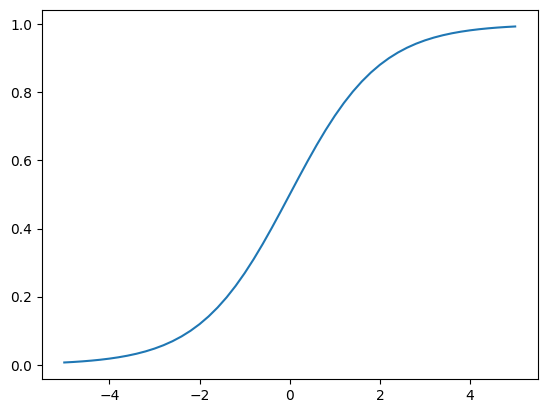

In [57]:
plt.plot(z, sigmoid(z))

In [ ]:
alt.Chart(pl.DataFrame({"value": z, "sigmoid": sigmoid(z)})).mark_line().encode(
    alt.X("value"), alt.Y("sigmoid")
)

alt.Chart(...)

In [59]:
def linear_regression(xi, w0, w):
    result = w0

    for j in range(len(w)):
        result = result + xi[j] * w[j]

    return result

In [60]:
def logistic_regression(xi, w0, w):
    score = w0

    for j in range(len(w)):
        score = score + xi[j] * w[j]

    result = sigmoid(score)
    return result

## 9. Training logistic regression with Scikit-Learn


In [61]:
model = LogisticRegression()
model.fit(X_train, y_train)

/home/nikki/workspace/ml-zoomcamp/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

This warning is because the data has not been scaled properly, with `totalcharges` having a higher amount compared to the others


In [62]:
model.intercept_[0]

np.float64(-0.10819072735550182)

In [ ]:
model.coef_[0].round(3)

array([ 0.471, -0.174, -0.404, -0.028, -0.079,  0.063, -0.088, -0.082,
       -0.034, -0.073, -0.334,  0.315, -0.088,  0.004, -0.257,  0.14 ,
        0.01 ,  0.062, -0.088, -0.081,  0.265, -0.088, -0.284, -0.231,
        0.124, -0.164,  0.057, -0.087, -0.032,  0.072, -0.06 ,  0.14 ,
       -0.246,  0.215, -0.12 , -0.088,  0.101, -0.071, -0.088,  0.051,
        0.213, -0.088, -0.232, -0.071,  0.   ])

In [64]:
# hard prediction
model.predict(X_train)

array([0, 1, 1, ..., 1, 0, 1], dtype=int8)

- Hard prediction
- Not churning or churning


In [65]:
# soft prediction
model.predict_proba(X_train)

array([[0.903815  , 0.096185  ],
       [0.32091512, 0.67908488],
       [0.36627175, 0.63372825],
       ...,
       [0.47110439, 0.52889561],
       [0.95699186, 0.04300814],
       [0.30148157, 0.69851843]])

- Soft prediction
- The probability of not churning and churning


In [66]:
y_pred = model.predict_proba(X_val)[:, 1]

In [67]:
churn_decision = y_pred >= 0.5

In [ ]:
df_val.filter(pl.lit(churn_decision))["customerid"]

customerid
str
"""8433_wxgna"""
"""3440_jpscl"""
"""2637_fkfsy"""
"""7228_omtpn"""
"""6711_fldfb"""
…
"""5976_jcjrh"""
"""2034_cgrhz"""
"""5276_kqwhg"""


In [69]:
y_val

array([0, 0, 0, ..., 0, 1, 1], dtype=int8)

In [70]:
churn_decision.astype(int)

array([0, 0, 0, ..., 0, 1, 1])

In [71]:
(y_val == churn_decision).mean()

np.float64(0.8026969481902059)

In [ ]:
df_pred = pl.DataFrame()
df_pred = df_pred.with_columns(
    pl.lit(y_pred).alias("probability"),
    pl.lit(churn_decision.astype(int)).alias("prediction"),
    pl.lit(y_val).alias("actual"),
)
df_pred = df_pred.with_columns(
    (pl.col("prediction") == pl.col("actual")).alias("correct"),
)
df_pred

probability,prediction,actual,correct
f64,i64,i8,bool
0.009034,0,0,true
0.206096,0,0,true
0.214327,0,0,true
0.543724,1,1,true
0.215992,0,0,true
…,…,…,…
0.310837,0,0,true
0.039368,0,1,false
0.136715,0,0,true


In [ ]:
df_pred["correct"].mean()

0.8026969481902059

## 10. Accuracy and dummy model


In [74]:
len(y_val)

1409

In [ ]:
(y_val == churn_decision).mean()

np.float64(0.8026969481902059)

In [ ]:
(y_val == churn_decision).mean() / len(y_val)

np.float64(0.0005696926530803448)

In [ ]:
thresholds = np.linspace(0, 1, 21)

scores = []
for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print(f"{t:.2f} {score:.3f}")
    scores.append(score)

0.00 0.274
0.05 0.508
0.10 0.591
0.15 0.666
0.20 0.709
0.25 0.737
0.30 0.760
0.35 0.773
0.40 0.785
0.45 0.792
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.734
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


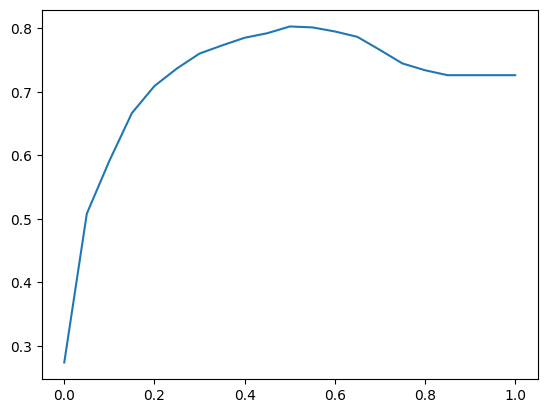

In [ ]:
plt.plot(thresholds, scores)

In [79]:
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

In [80]:
1 - y_val.mean()

np.float64(0.7260468417317246)

## 11. Confusion table


In [81]:
actual_positive = y_val == 1
actual_negative = y_val == 0

In [82]:
t = 0.5
predict_positive = y_pred >= t
predict_negative = y_pred < t

In [83]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [84]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [ ]:
confusion_table = np.array(
    [
        [tn, fp],
        [fn, tp],
    ]
)
confusion_table

array([[921, 102],
       [176, 210]])

- `fp`: we're losing money, because these people will not churn, but we give them email discounts anyway
- `fn`: we're losing profit, because these people churn and we failed to give them email discounts. Seems to be more difficult to catch in this case


In [86]:
(confusion_table / confusion_table.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## 12. Precision and Recall


In [87]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
accuracy

np.float64(0.8026969481902059)

`Precision` = fraction of positive prections that are correct (`true positive` / `predict positive`)


In [88]:
tp / predict_positive.sum()

np.float64(0.6730769230769231)

In [89]:
precision = tp / (tp + fp)
precision


np.float64(0.6730769230769231)

`Recall` = fraction of correctly identified positive (`true positive` / `actual positive`)

- Important when we identifying positive is so important
- Like detecting a disease


In [90]:
tp / actual_positive.sum()

np.float64(0.5440414507772021)

In [91]:
recall = tp / (tp + fn)
recall


np.float64(0.5440414507772021)

## 13. ROC Curves

- False Positive Rate - minimize
- True Positive Rate (Recall) - maximize


In [92]:
tpr = tp / (tp + fn)
tpr

np.float64(0.5440414507772021)

In [93]:
fpr = fp / (fp + tn)
fpr

np.float64(0.09970674486803519)

In [94]:
thresholds = np.linspace(0, 1, 101)

scores = []

for t in thresholds:
    actual_positive = y_val == 1
    actual_negative = y_val == 0

    predict_positive = y_pred >= t
    predict_negative = y_pred < t

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))


In [95]:
cols = ["threshold", "tp", "fp", "fn", "tn"]
df_scores = pl.DataFrame(scores, schema=cols, orient="row")

In [96]:
df_scores[::10]

threshold,tp,fp,fn,tn
f64,i64,i64,i64,i64
0.0,386,1023,0,0
0.1,366,556,20,467
0.2,333,357,53,666
0.3,284,236,102,787
0.4,249,166,137,857
…,…,…,…,…
0.6,150,53,236,970
0.7,75,19,311,1004
0.8,12,1,374,1022


In [97]:
df_scores = df_scores.with_columns(
    (pl.col("tp") / (pl.col("tp") + pl.col("fn"))).alias("tpr"),
    (pl.col("fp") / (pl.col("fp") + pl.col("tn"))).alias("fpr"),
)

In [98]:
df_scores[::10]

threshold,tp,fp,fn,tn,tpr,fpr
f64,i64,i64,i64,i64,f64,f64
0.0,386,1023,0,0,1.0,1.0
0.1,366,556,20,467,0.948187,0.5435
0.2,333,357,53,666,0.862694,0.348974
0.3,284,236,102,787,0.735751,0.230694
0.4,249,166,137,857,0.645078,0.162268
…,…,…,…,…,…,…
0.6,150,53,236,970,0.388601,0.051808
0.7,75,19,311,1004,0.194301,0.018573
0.8,12,1,374,1022,0.031088,0.000978


In [99]:
alt.Chart(df_scores).transform_fold(["tpr", "fpr"]).mark_line().encode(
    alt.X("threshold:Q"), alt.Y("value:Q"), alt.Color("key:N")
)

alt.Chart(...)

### Random model


In [100]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [101]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [102]:
def tpr_fpr_dataframe(y_val, y_pred):
    thresholds = np.linspace(0, 1, 101)

    scores = []

    for t in thresholds:
        actual_positive = y_val == 1
        actual_negative = y_val == 0

        predict_positive = y_pred >= t
        predict_negative = y_pred < t

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    cols = ["threshold", "tp", "fp", "fn", "tn"]
    df_scores = pl.DataFrame(scores, schema=cols, orient="row")

    df_scores = df_scores.with_columns(
        (pl.col("tp") / (pl.col("tp") + pl.col("fn"))).alias("tpr"),
        (pl.col("fp") / (pl.col("fp") + pl.col("tn"))).alias("fpr"),
    )

    return df_scores

In [ ]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

threshold,tp,fp,fn,tn,tpr,fpr
f64,i64,i64,i64,i64,f64,f64
0.0,386,1023,0,0,1.0,1.0
0.1,347,923,39,100,0.898964,0.902248
0.2,307,822,79,201,0.795337,0.803519
0.3,276,724,110,299,0.715026,0.707722
0.4,237,624,149,399,0.61399,0.609971
…,…,…,…,…,…,…
0.6,161,409,225,614,0.417098,0.399804
0.7,121,302,265,721,0.313472,0.29521
0.8,78,206,308,817,0.202073,0.201369


In [ ]:
alt.Chart(df_rand).transform_fold(["tpr", "fpr"]).mark_line().encode(
    alt.X("threshold:Q"), alt.Y("value:Q"), alt.Color("key:N")
)


alt.Chart(...)

### Ideal model


In [105]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [106]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [107]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [108]:
1 - y_val.mean()

np.float64(0.7260468417317246)

In [109]:
((y_ideal_pred >= 0.726) == y_ideal).mean()


np.float64(1.0)

In [110]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

In [111]:
df_ideal[::10]

threshold,tp,fp,fn,tn,tpr,fpr
f64,i64,i64,i64,i64,f64,f64
0.0,386,1023,0,0,1.0,1.0
0.1,386,882,0,141,1.0,0.86217
0.2,386,741,0,282,1.0,0.72434
0.3,386,600,0,423,1.0,0.58651
0.4,386,459,0,564,1.0,0.44868
…,…,…,…,…,…,…
0.6,386,178,0,845,1.0,0.173998
0.7,386,37,0,986,1.0,0.036168
0.8,282,0,104,1023,0.73057,0.0


In [ ]:
alt.Chart(df_ideal).transform_fold(["tpr", "fpr"]).mark_line().encode(
    alt.X("threshold:Q"), alt.Y("value:Q"), alt.Color("key:N")
)


alt.Chart(...)

### Putting everything together


In [ ]:
alt.layer(
    alt.Chart(df_scores)
    .transform_fold(["tpr", "fpr"])
    .mark_line()
    .encode(alt.X("threshold:Q"), alt.Y("value:Q"), alt.Color("key:N")),
    # alt.Chart(df_rand)
    # .transform_fold(["tpr", "fpr"])
    # .mark_line()
    # .encode(alt.X("threshold:Q"), alt.Y("value:Q"), alt.Color("key:N")),
    alt.Chart(df_ideal)
    .transform_fold(["tpr", "fpr"])
    .mark_line(color="black")
    .encode(alt.X("threshold:Q"), alt.Y("value:Q"), alt.Color("key:N")),
)

alt.LayerChart(...)

In [114]:
alt.layer(
    alt.Chart(df_scores)
    .mark_line()
    .encode(alt.X("fpr:Q"), alt.Y("tpr:Q"), alt.Color()),
    alt.Chart(df_rand)
    .mark_line(color="orange")
    .encode(alt.X("fpr:Q"), alt.Y("tpr:Q"), alt.Color()),
)

alt.LayerChart(...)

In [115]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

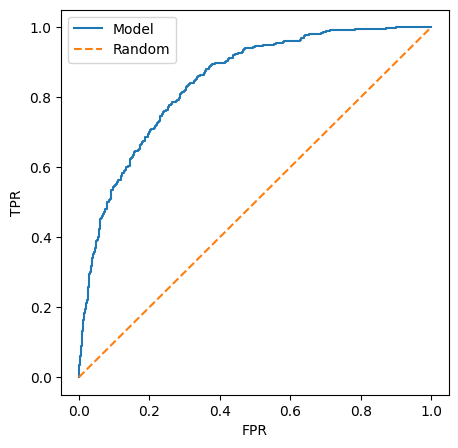

In [116]:
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label="Model")
plt.plot([0, 1], [0, 1], label="Random", linestyle="--")

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.legend()

plt.show()

## 14. ROC AUC


In [ ]:
auc(fpr, tpr)

np.float64(0.8438884921418767)

In [118]:
auc(df_scores["fpr"], df_scores["tpr"])

np.float64(0.8436415804375021)

In [119]:
auc(df_ideal["fpr"], df_ideal["tpr"])

np.float64(0.9999430203759136)

In [120]:
roc_auc_score(y_val, y_pred)

np.float64(0.8438884921418767)

In [121]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [122]:
random.seed(1)
n = 100000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success += 1

success / n

0.84376

In [123]:
np.random.seed(1)
n = 100000
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.84287)

## 15. Cross-Validation


In [124]:
def train(df, y_train, C=1.0):
    dicts = df.select(pl.col(categorical + numerical)).to_dicts()

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=10000)
    model.fit(X_train, y_train)

    return dv, model

In [125]:
dv, model = train(df_train, y_train, C=0.001)

In [126]:
def predict(df, dv, model):
    dicts = df.select(pl.col(categorical + numerical)).to_dicts()

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [127]:
y_pred = predict(df_val, dv, model)

In [128]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    scores = []

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train[train_idx]
        df_val = df_full_train[val_idx]

        y_train = df_train["churn"].to_numpy()
        y_val = df_val["churn"].to_numpy()

        dv, model = train(df_train, y_train, C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print("C=%s %.3f +- %.3f" % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:03<00:18,  3.01s/it]

C=0.001 0.825 +- 0.009


 29%|██▊       | 2/7 [00:15<00:41,  8.35s/it]

C=0.01 0.840 +- 0.008


 43%|████▎     | 3/7 [00:42<01:07, 16.82s/it]

C=0.1 0.842 +- 0.007


 57%|█████▋    | 4/7 [00:57<00:48, 16.18s/it]

C=0.5 0.842 +- 0.007


 71%|███████▏  | 5/7 [01:16<00:34, 17.25s/it]

C=1 0.842 +- 0.007


 86%|████████▌ | 6/7 [01:37<00:18, 18.46s/it]

C=5 0.842 +- 0.007


100%|██████████| 7/7 [01:58<00:00, 16.94s/it]

C=10 0.842 +- 0.007


In [129]:
scores

[np.float64(0.8439018454992897),
 np.float64(0.8447246225665475),
 np.float64(0.8336343568131647),
 np.float64(0.8347848852081603),
 np.float64(0.8519853471808226)]

In [130]:
dv, model = train(df_full_train, df_full_train["churn"].to_numpy(), C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc


np.float64(0.8584005005037537)